In [ ]:
try:
    import pyro
except:
    ! pip install pyro-ppl
    ! pip install Biopython

     |████████████████████████████████| 718 kB 4.8 MB/s 
     |████████████████████████████████| 2.3 MB 4.8 MB/s 


## Latent Tree

In [ ]:
import pyro
import torch
from helper import *
from PyroModel import *
from JAXFunctions import *
from Error_measure import *
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO
from sklearn.manifold import TSNE
from scipy.stats import spearmanr, pearsonr
import os
import re

from ASR import ASR

from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

import pickle
import math

In [ ]:
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [ ]:
AA_dict, back_AA_dict = get_AA_dict(n_c=24)
S_train, S_names_train, S_length_train, S_char_train = load_Unaligned_Data("/content/BLAT_ECOLX_1_b0.5.fasta", "cuda", AA_dict)

S_down_train, S_names_down_train, S_length_down_train, S_char_down_train = load_Unaligned_Data("//content/mutation.fas", "cuda", AA_dict)

In [ ]:
Classify_train_p = []
Classify_test_p = []

Classify_train_s = []
Classify_test_s = []

Rec_Acc = []
Rec_Acc_remove_gap = []

In [ ]:
with open("/content/Labels.pkl", "rb") as f:
    Labels = pickle.load(f)

  0%|          | 0/21 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/distributions/dirichlet.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  torch.lgamma(self.concentration.sum(-1)) -
100%|██████████| 21/21 [2:15:12<00:00, 386.32s/it]


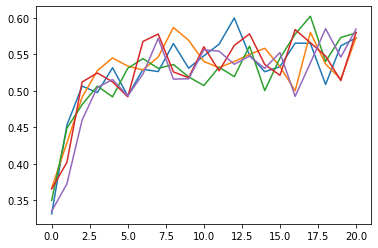

100%|██████████| 21/21 [2:22:01<00:00, 405.79s/it]


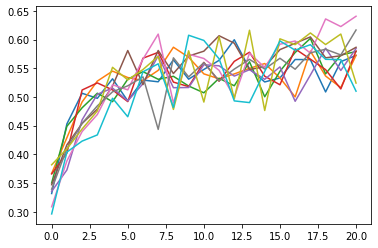

100%|██████████| 21/21 [2:10:13<00:00, 372.08s/it]


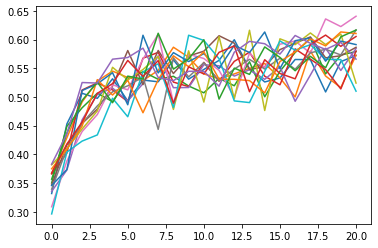

100%|██████████| 21/21 [2:17:04<00:00, 391.64s/it]


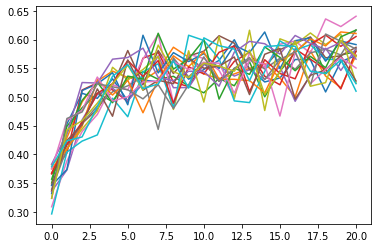

100%|██████████| 21/21 [2:14:28<00:00, 384.19s/it]


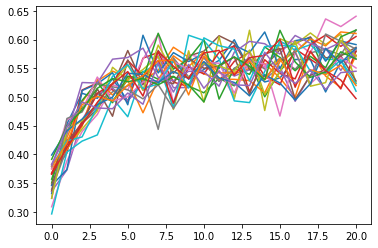

In [ ]:
for _ in range(5):

    for _ in range(5):
        Classify_train_p.append([])
        Classify_test_p.append([])

        Classify_train_s.append([])
        Classify_test_s.append([])

    Rec_Acc.append([])
    Rec_Acc_remove_gap.append([])
    
    

    msa_ref = nn.Softmax(-1)(torch.randn(int(S_train.shape[1]), 23, device="cuda"))
    pyro.clear_param_store()
    vae = VAE(50, 24, msa_ref.shape[0])
    def per_param_callable(module_name, param_name):
        if param_name in ["Blosum"]:
            return {"lr": 1e-6, "clip_norm": 10}
        elif param_name in ["sigma_f_loc", "sigma_n_loc", "lambd_loc"]:
            return {"lr": 5e-4, "clip_norm": 10}
        else:   
            return {"lr": 0.0005, "clip_norm": 10}
    optimizer = pyro.optim.ClippedAdam(per_param_callable)
    svi = SVI(vae.batched_model_latent_tree, vae.batched_guide_latent_tree, optimizer, loss=Trace_ELBO(num_particles=1))

    S_ave_pos = []
    for b in tqdm(range(21)):
        batch_size = 50
        indices = np.random.choice(S_train.shape[0], S_train.shape[0], False)
        for batch in range(S_train.shape[0] // batch_size - 1):
          batch_idx = indices[batch * batch_size: batch * batch_size + batch_size]
          back_idx = indices[S_train.shape[0] // batch_size * batch_size - batch_size:]
          all_idx = np.concatenate([back_idx, batch_idx])

          elbo = svi.step(Unaligned_S=S_train[batch_idx],
                  S_length=np.array(S_length_train)[batch_idx].tolist(),
                  S_index=batch_idx,
                  msa_ref=msa_ref,
                  S_ave_pos=S_ave_pos,
                  num_batch=S_train.shape[0] // batch_size - 1,
                  Unaligned_S_back=S_train[back_idx],
                  S_back_length=np.array(S_length_train)[back_idx].tolist(),
                  S_back_index=back_idx,
                  num_instance=S_train.shape[0],
                  tree_emb_dim=100,
                  regularization_D=False)
          if batch % 5 == 0 and b <= 10:
              msa_ref_epoch = torch.cat(S_ave_pos, dim=0).sum(dim=0) + 1e-3
              msa_ref_epoch /= msa_ref_epoch.sum(-1, True)

              msa_ref = msa_ref_epoch * 0.05 + msa_ref * 0.95
              S_ave_pos = [] # clear

        with torch.no_grad():

            # downstream tast
            S_onehot = torch.zeros_like(S_down_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_down_train[:, :, None], 1).float().cuda()
            MSA = S_onehot[:, :, :].float().cuda()

            ref_emb = msa_ref
            mask = (torch.arange(S_down_train.shape[1])[None, :] < torch.tensor(S_length_down_train)[:, None]).to(vae.device)
            s_emb = (S_onehot * mask[:, :, None])[:, :, :-1]
            
            path = []
            for i in range(int(math.ceil(S_down_train.shape[0] / batch_size))):
                similar_tensor = ref_emb @ pyro.param("Blosum").detach() @ s_emb[i * batch_size: (i + 1) * batch_size].transpose(1, 2)
                path.append(
                    snw(similar_tensor, list(S_length_down_train)[i * batch_size: (i + 1) * batch_size], vae.nw_fn).detach()
                )
            path = torch.cat(path, dim=0)
            MSA = path @ S_onehot # N, L, l @ N, l, n_c


            MSA[:, :, -1] = MSA[:, :, -1] + 1 - path.sum(-1)  # fill the gaps with onehot-encoding of "-"
            
            label_down = np.array([Labels[i] for i in S_names_down_train])

            np.random.seed(42)
            indices = np.random.choice(label_down.shape[0], label_down.shape[0], False)
            np.random.seed(None)

            indices_train = indices[: int(indices.shape[0] * 0.7)]
            indices_test = indices[int(indices.shape[0] * 0.7):]

            label_train = label_down[indices_train]
            label_test = label_down[indices_test]
            
            x_down = vae.encoder(MSA, None).detach().cpu()#torch.cat([vae.encoder(MSA_down, None).detach().cpu(), vae.encoder(MSA_down_wt, None).detach().cpu()], dim=-1)

            x_train = x_down[indices_train]
            x_test = x_down[indices_test]#[test_idx]

            for _i in range(5):

                #classifier = MLPRegressor((100, 300, 300, 100), alpha=0.3, max_iter=500).fit(x_train, label_train)
                classifier = MLPRegressor((100, 300, 100), alpha=0.3, max_iter=500).fit(x_train, label_train)
                acc_train = pearsonr(label_train, classifier.predict(x_train))[0]
                Classify_train_p[-1-_i].append(acc_train)

                acc_train = spearmanr(label_train, classifier.predict(x_train))[0]
                Classify_train_s[-1-_i].append(acc_train)

                acc_test = pearsonr(label_test, classifier.predict(x_test))[0]
                Classify_test_p[-1-_i].append(acc_test)

                acc_test = spearmanr(label_test, classifier.predict(x_test))[0]
                Classify_test_s[-1-_i].append(acc_test)

    for i in Classify_test_p:
        plt.plot(i)
    plt.show()


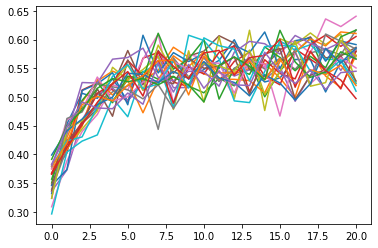

In [ ]:
for i in Classify_test_p:
  plt.plot(i)

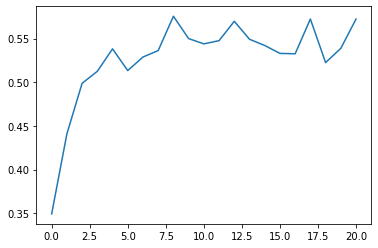

In [ ]:
plt.plot(np.array(Classify_test_p[:2]).mean(0))

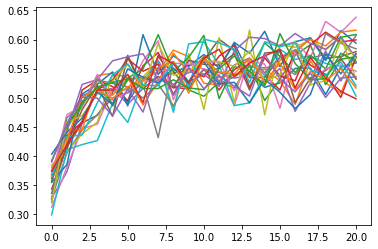

In [ ]:
for i in Classify_test_s:
  plt.plot(i)

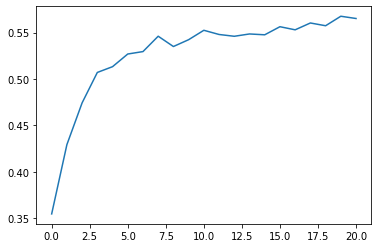

In [ ]:
plt.plot(np.array(Classify_test_s).mean(0))

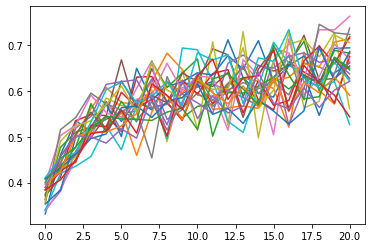

In [ ]:
for i in Classify_train_p:
  plt.plot(i)

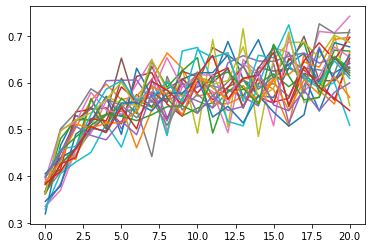

In [ ]:
for i in Classify_train_s:
  plt.plot(i)

In [ ]:
import pickle

with open("track_snw.pkl", "wb") as f:
    pickle.dump((Classify_train_p, Classify_test_p, Classify_train_s, Classify_test_s, Rec_Acc, Rec_Acc_remove_gap), f)

from google.colab import files
files.download("track_snw.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>